In [2]:
import numpy as np
import pandas as pd

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
spam_dataset = pd.read_csv('spam.csv', encoding = "ISO-8859-1", usecols=[0, 1], names=['Spam', 'Text'],
                           skiprows=1)
spam_dataset['Spam'] = spam_dataset['Spam'].map({'ham': 0, 'spam': 1})

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    spam_dataset['Text'],
    spam_dataset['Spam'],
    test_size = 0.2,
    random_state = 42,
    stratify = spam_dataset['Spam']
    )

In [5]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        processed = []
        for text in X:
            text = text.lower()
            tokens = word_tokenize(text)
            tokens = [t for t in tokens 
                      if t not in string.punctuation 
                      and t not in self.stop_words]
            tokens = [self.lemmatizer.lemmatize(t) for t in tokens]
            processed.append(" ".join(tokens))
        return processed

pipeline = Pipeline([
    ('preprocessing', TextPreprocessor()),
    ('tfidf', TfidfVectorizer(
        max_df=0.5, 
        min_df=0.001, 
        ngram_range=(2, 2), 
        use_idf=True
    )),
    ('clf', RandomForestClassifier(random_state=42))
], memory=None)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing', TextPreprocessor()),
                ('tfidf',
                 TfidfVectorizer(max_df=0.5, min_df=0.001, ngram_range=(2, 2))),
                ('clf', RandomForestClassifier(random_state=42))])

In [6]:
importances = pipeline.named_steps['clf'].feature_importances_
feature_names = pipeline.named_steps['tfidf'].get_feature_names_out()

importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print(importances_df.head(15))
print(importances_df.shape)

              feature  importance
98              co uk    0.056266
316       please call    0.028868
361         send stop    0.023431
90         chance win    0.022567
322            po box    0.022478
426          txt stop    0.021569
117  customer service    0.020502
94         claim call    0.016983
118    dating service    0.016799
427          txt word    0.014505
16           150p msg    0.013902
433        ur awarded    0.013472
342        reply stop    0.013332
10          1000 cash    0.013032
357  selected receive    0.012619
(499, 2)


In [7]:
threshold = 0.001
mask = (importances >= threshold)  

X_train_full = pipeline[:-1].transform(X_train)
X_test_full = pipeline[:-1].transform(X_test)

X_train_selected = X_train_full[:, mask]
X_test_selected  = X_test_full[:, mask]

print("X_train_selected shape:", X_train_selected.shape)

X_train_selected shape: (4457, 185)


In [8]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced'],
}

second_rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=second_rf,
    param_grid=param_grid,
    scoring='f1',
    cv=5,        
    n_jobs=-1,   
    verbose=2    
)

grid_search.fit(X_train_selected, y_train)

print("Best params:", grid_search.best_params_)
print("Best CV F1:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_selected)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Best CV F1: 0.8234333532913078
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       966
           1       0.94      0.71      0.81       149

    accuracy                           0.96      1115
   macro avg       0.95      0.85      0.89      1115
weighted avg       0.95      0.96      0.95      1115



c:\Users\Urban\.conda\envs\kodilla-edu\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


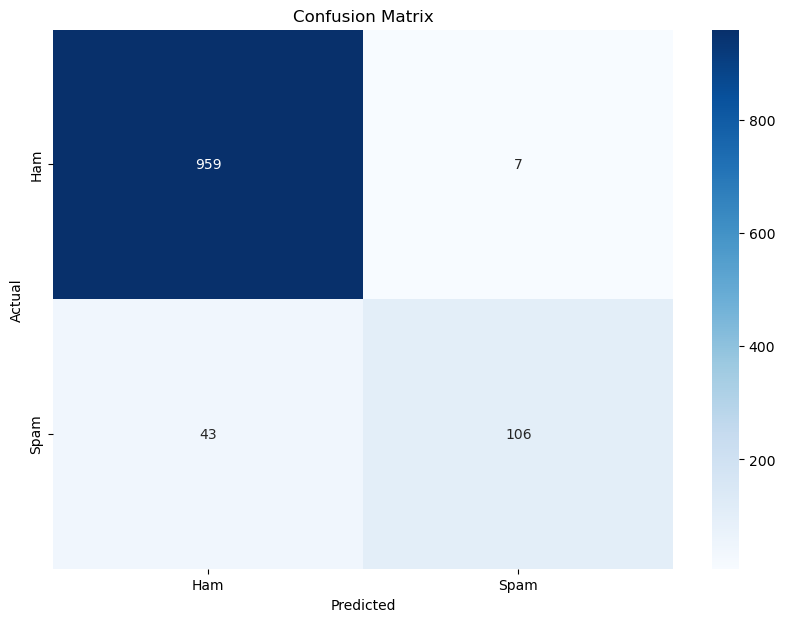

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

ROC AUC: 0.8637708949935387


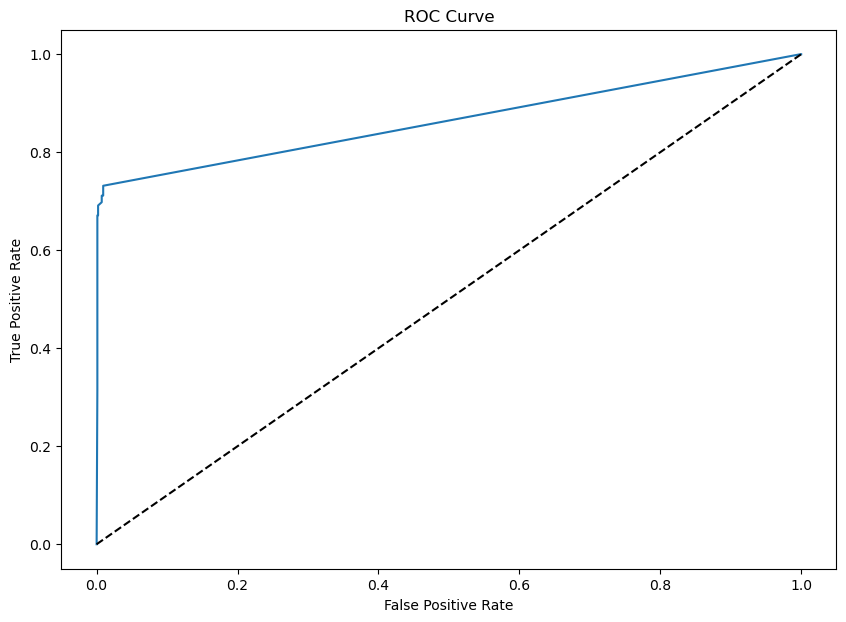

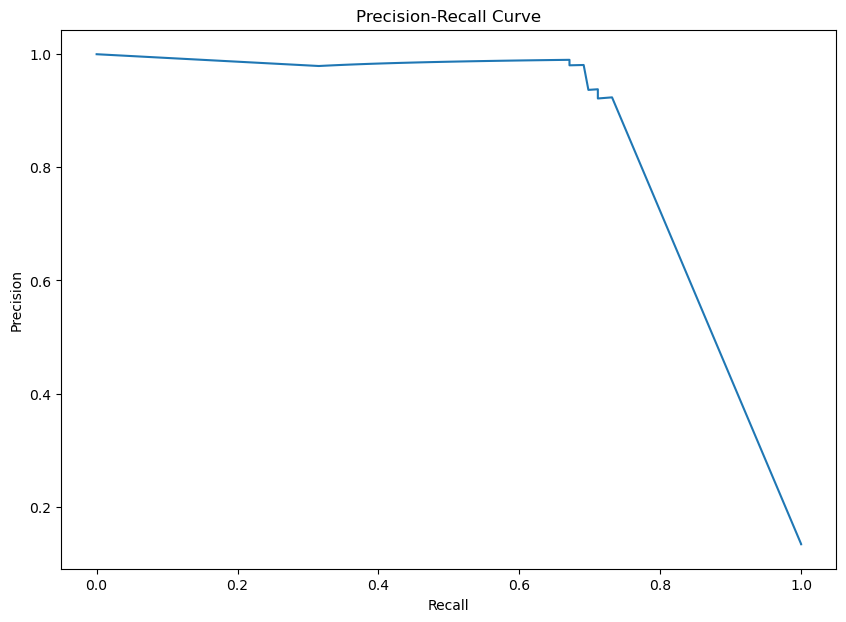

F1 score: 0.8091603053435115


In [10]:
# ROC AUC score
from sklearn.metrics import roc_auc_score

y_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC:", roc_auc)

# ROC curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Precision-recall curve
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 7))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# F1 score
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred)
print("F1 score:", f1)